# HW11: 歌曲种类分类

如果有问题请在群里讨论，题意问题请@姜腾

ddl周六（4.16）23:59，提交前请自己重启kernel运行一遍，只提交ipynb文件，不要把数据打包

由于大家期中临近，所以这次作业很大一部分已经由助教给出。尤其是对英文语料预处理的部分，只是希望大家注意一下处理英文语料和中文语料的差别之处，比如需要Lemmatization（比如把过去式还原），还有去除停词。

基本任务描述：
本数据集是已经整理拼接好的数据集，包含了r&b, latin, rock, pop, rap, edm六个音乐种类的歌曲的歌词和音频特征。

特征部分是用的Spotify的api提供的音频分析数据，已经由原音频文件特征工程得来（如果大家对音频分析感兴趣，可以去搜一下[librosa](http://librosa.org/doc/latest/index.html)包，是专业分析音频的包。12个音频特征如下: acousticness, danceability, durationms, energy, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, valence.具体含义参考[链接](https://developer.spotify.com/web-api/get-audio-features/)，比如key的1和0就是大小调的区别。

为了任务简单，本次只用rock, pop, rap三种的音乐，每种抽样1500首歌。预测目标是playlist_genre，即歌曲所属的歌单表征歌曲的种类。

In [13]:
# 可能用到的包
import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
# 也有可能用到其他的方法，比如什么Complement Naive Bayes，如果你觉得有必要的话

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import nltk
import re
# from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import seaborn as sns
import matplotlib.pyplot as plt
import warnings

random.seed(1)
# nltk.download('stopwords')
warnings.filterwarnings('ignore')

In [14]:
with open('./english', 'r', encoding='utf-8') as f:
	stop_words = f.readlines()  # 读取全部内容后，按行存储为list
stop_words = set(i.strip('\n') for i in stop_words)

In [15]:
# 数据读入和预处理

nRowsRead = None # specify 'None' if want to read whole file
data = pd.read_csv('./spotify_songs.csv', delimiter=',', nrows = nRowsRead)

# data preprocessing

# step1: Removing Numbers, Punctuations and Lowercasing the Words¶

def rid_of_specials(lyrics):
    return re.sub('[^A-Za-z]+', ' ', lyrics).lower()
data["lyrics"] = data["lyrics"].astype(str).apply(rid_of_specials)


# step2: remove stopwords

#sw_nltk = (stopwords.words('english'))
#stop_words = set(sw_nltk)

def remove_sw(x):
    x = x.split(' ')
    return  ' '.join(z for z in x if z not in stop_words)
stopped = data["lyrics"].apply(remove_sw)

# step3: lemmatizing
lemmatizer = WordNetLemmatizer()
lemmatized = [lemmatizer.lemmatize(i) for i in stopped]
prepeared_sentence = [''.join(j) for j in lemmatized]
data['Lyrics_Processed'] = prepeared_sentence

In [16]:
data.columns

Index(['track_id', 'track_name', 'track_artist', 'lyrics', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'language', 'Lyrics_Processed'],
      dtype='object')

In [17]:
data['playlist_genre'].value_counts()

pop      3993
rock     3521
rap      3391
r&b      3326
latin    2178
edm      2045
Name: playlist_genre, dtype: int64

In [18]:
data = data[data['language']=='en'] # 只选出英文歌
# 只留下pop，rock和rap
data = data[data['playlist_genre']!='latin']
data = data[data['playlist_genre']!='edm']
data = data[data['playlist_genre']!='r&b']
data = data.groupby('playlist_genre').apply(lambda x: x.sample(n=1500)) #每种乐曲选出1500首

### 任务1: 只使用歌词

歌词已经处理好了，任务为**只用歌词**实现朴素贝叶斯分类（注意一下使用哪种Naive Bayes）和Logistic回归分类。将歌词按照课上讲过的方法通过Count Vectorization或者TF-IDF Vectorization向量化作为特征输入训练模型，最后打印在测试集上的classification_report和confusion matrix。

提示：强烈建议直接调包，会很简单的。可能用到的方法已经在最前面给出了。
如果你遇到了TFIDF Vector能不能用于Multinomial Bayes的问题，这一篇blog或许可以解答你的疑惑。https://stackoverflow.com/questions/43237286/how-can-we-use-tfidf-vectors-with-multinomial-naive-bayes

In [ ]:
# todo

### 任务2: 接下来考虑加入音频特征，只使用朴素贝叶斯方法。流程如下：

1. 接着上一问，使用训练集训练的朴素贝叶斯模型去在整个数据集做预测，得到三个种类的预测probability，将其中的两个维度（因为三者加和为1）作为两个新的特征和'danceability', 'energy', 'valence', 'speechiness'这四个音频特征中拼接在一起（concatenate），作为新的特征（如果你觉得有必要的话，可以对特征进行进一步处理），这样的话特征应该被拼接为了4500*6的矩阵；
2. 使用新的特征，选择合适的朴素贝叶斯分类器，再次进行训练；
3. 最后打印在测试集上的classification_report和confusion matrix；
4. 你觉得这么操作有意义/符合前提假设吗？请说明。

提示：强烈建议直接调包，会很简单的。model.predict_proba(X)可以调出模型给出的分为各类的预测概率。关于最后一步，有时候理论正确的方法不一定有好的效果，有好的效果的方法不一定理论正确，看你自己的理解。

In [ ]:
# todo

### 附加题（2分）：

对于音频特征，12个维度有点太过冗余了，实则12个特征全部直接使用效果也不好。我们如何选择出最合适的音频特征（3～5个）？应该对特征做什么样处理？用代码展示你寻找最佳特征组合并以合理方式处理特征的过程并说明背后的原理，同样要求最后打印在测试集上的classification_report和confusion matrix。在这一问中你可以只使用音频特征来进行朴素贝叶斯分类，也可以用你的方法结合音频和歌词文本特征。

提示
1. 可以通过eda（Exploratory Data Analysis）来首先看一看数据的情况
2. 使用老师“查看最有用的特征”一页的方法

原本的附加题可能被延伸为大作业。祝大家期中顺利～

In [19]:
# todo

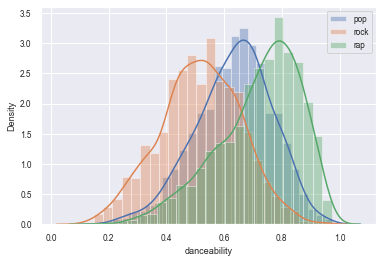

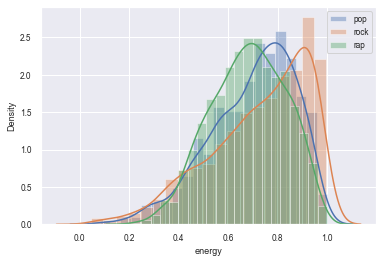

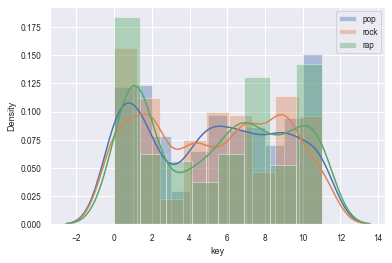

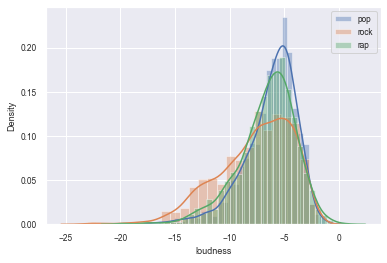

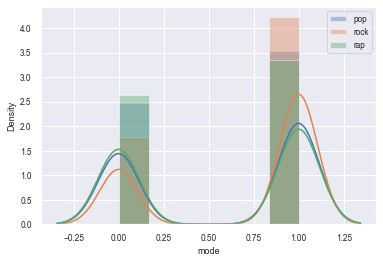

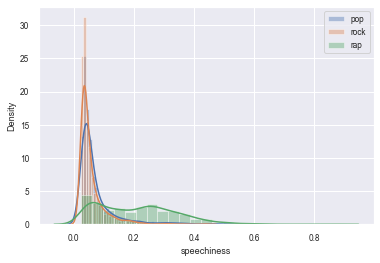

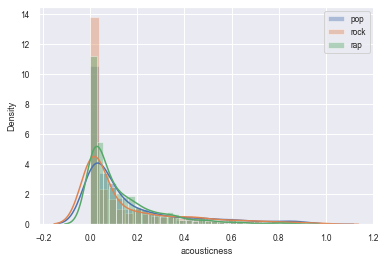

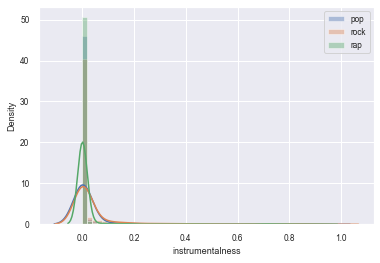

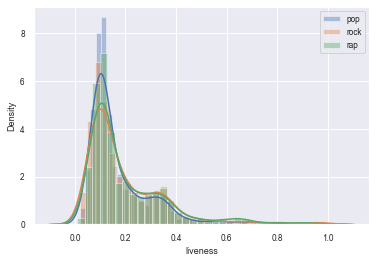

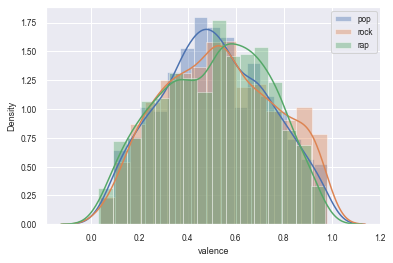

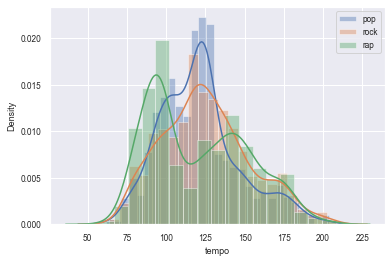

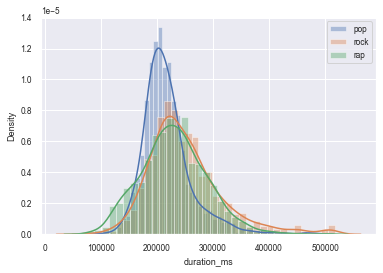

In [17]:
# 一些EDA仅供参考
def plot_density(feature):
    sns.distplot(data[data['playlist_genre']=='pop'][feature],label = 'pop') # 用displot or histplot也行
    sns.distplot(data[data['playlist_genre']=='rock'][feature],label = 'rock')
    sns.distplot(data[data['playlist_genre']=='rap'][feature],label = 'rap')
    plt.legend()
    plt.show()
for i in ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms']:
       plot_density(i)

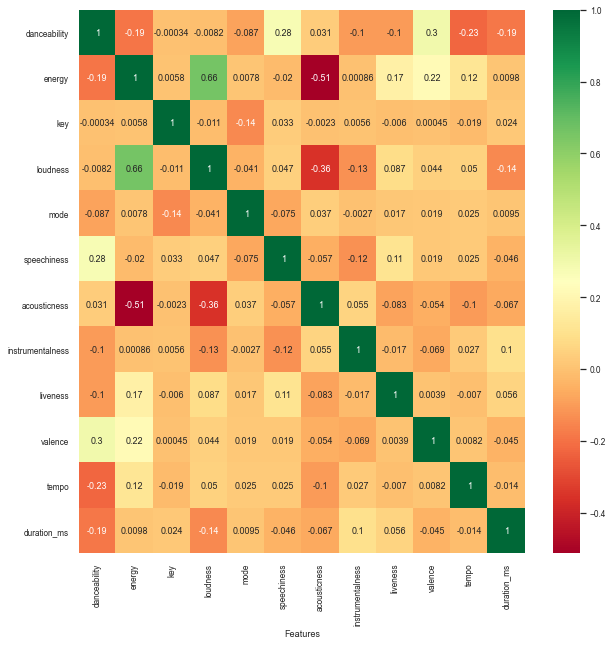

In [18]:
f,ax = plt.subplots(figsize = (10,10)) #the size of the heat map
sns.heatmap(data.loc[:,['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms']].corr(), annot = True, fmt = '.2g', cmap = 'RdYlGn', ax= ax)
sns.set(font_scale = 0.75) #the font size of the value in the heat map
plt.xlabel('Features')
plt.show()